# Exercise 4 Camera calibration 

In this exercise we will look at:
- Direct linear transform (DLT), linear algorithm for camera calibration and
- Checkerboard calibration, and bundle adjustment from Zhang (2000).

You should be able to perform camera calibration using both methods.

In [1]:
from ex1 import box3d, projectpoints
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
from scipy.spatial.transform import Rotation

#### 4.1 DLT Direct linear transformation

In [2]:
# Pose matrices:
R = np.array([[np.sqrt(0.5), -np.sqrt(0.5), 0], [np.sqrt(0.5), np.sqrt(0.5), 0], [0, 0, 1]])
t = np.array([[0, 0, 10]]).T

f = 1000
dx = 1920//2
dy = 1080//2
K = np.array([[f, 0, dx], [0, f, dy], [0, 0, 1]])
K

array([[1000,    0,  960],
       [   0, 1000,  540],
       [   0,    0,    1]])

In [3]:
# Exact 3D points
Q = np.array([[0, 1, 0, 1, 0, 1, 0, 1], [0, 0, 1, 1, 0, 0, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1]])
Q

array([[0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1]])

In [10]:
P_exact = K@np.hstack((R, t))
np.int32(P_exact)

array([[ 707, -707,  960, 9600],
       [ 707,  707,  540, 5400],
       [   0,    0,    1,   10]])

In [11]:
Q_h = np.vstack((Q, np.ones(len(Q[0]))))

In [13]:
q_h = P_exact@Q_h
q = q_h[0:2, :]/q_h[2, :]
for i in range(len(q[0])):
    print(np.round(q[:,i],2), end=", ")

[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 

#### 4.2 DLT

1. Use Q and q to estimate Projection matrix.
2. Normalize the points in Q before estimating Projection. 

In [48]:
def crossop(q):
    return np.array([[0, -q[2], q[1]], [q[2], 0, -q[0]], [-q[1], q[0], 0]])
    
def get_b(Q,q):
    """Calculates the B matrix by using kronecker multiplication and crossup."""
    B = np.kron(Q[:,0], crossop(q[:,0]))
    for i in range(1,len(q[0])):
        B_temp = np.kron(Q[:,i], crossop(q[:,i]))
        B = np.vstack((B,B_temp))
    return B

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def estimate_P(Q_h, q_h, normalize=False):
    if normalize:
        q_h, T = normalize2d(q_h)
    B = get_b(Q_h, q_h)
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(A.T@A)
    # VT is sorted in descending order of singular value
    P =  VT[-1] # VT is flattened, P is a 3x4
    P = P.reshape((4,3)).T
    if normalize:
        P = np.linalg.inv(T)@P # Turn back the normalization
    P = (P/P[-1, -1] * 10)
    #print(np.int32(P)) # Getting it on the same format as the original P
    return P

def print_matrix(M):
    print("[", end="")
    for i in range(len(M)):
        if i==0:
            print("[", end="")
        else:
            print(" [", end="")
        for j in range(len(M[i])):
            if j==len(M[i])-1:
                print(np.round(M[i][j], 2), end= "]\n")
            else:
                print(np.round(M[i][j], 2), end= " ")

In [49]:
P_est_1 = estimate_P(Q_h.copy(), q_h.copy(), normalize=False)
P_est_2 = estimate_P(Q_h.copy(), q_h.copy(), normalize=True)

In [50]:
print("P_exact:")
print_matrix(P_exact)
print("P estimated 1")
print_matrix(P_est_1)
print("P estimated 2")
print_matrix(P_est_2)

P_exact:
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [0.0 0.0 1.0 10.0]
P estimated 1
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [-0.0 0.0 1.0 10.0]
P estimated 2
[[707.11 -707.11 960.0 9600.0]
 [707.11 707.11 540.0 5400.0]
 [0.0 -0.0 1.0 10.0]


In [51]:

# Recalculate points
q_h_est_1 = P_est_1@Q_h
q_h_est_2 = P_est_2@Q_h
# Transform to nonhomogenous points
q_est_1 = q_h_est_1[0:2, :]/q_h_est_1[2, :]
q_est_2 = q_h_est_2[0:2, :]/q_h_est_2[2, :]

In [54]:
for i in range(len(q[0])):
    print(np.round(q[:,i],2), end=", ")
print("\n---------------------------------------------")
for i in range(len(q[0])):
    print(np.round(q_est_1[:,i],2), end=", ")
print("\n---------------------------------------------")
for i in range(len(q[0])):
    print(np.round(q_est_2[:,i],2), end=", ")
print("\n---------------------------------------------")


[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------
[960. 540.], [1030.71  610.71], [889.29 610.71], [960.   681.42], [960. 540.], [1024.28  604.28], [895.72 604.28], [960.   668.56], 
---------------------------------------------


In [58]:
print(np.linalg.norm(q_est_1-q))
print(np.linalg.norm(q_est_2-q))

1.0621062761322725e-08
3.8222027442951554e-08


## Programming: Checkerboard calibration using Zhangs method

Here we will prepare calibration with checkerboards. We do not yet have the ability to detect
checkerboards, so for now we will define the points ourselves.

#### 4.3 Define a checkerboard


In [71]:
def checkerboard_points(n,m):
    Q = np.zeros(shape=(3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*n+j] = [i - (n-1)/2.0,
                        j - (m-1)/2.0,
                        0]
                
    return Q

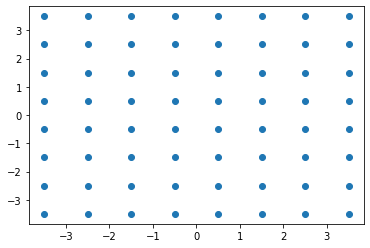

In [75]:
checkerboard = checkerboard_points(8,8)
plt.scatter(checkerboard[0,:], checkerboard[1,:])

#### 4.4 Checkerboard corners

```
R = Rotation.from_euler('xyz', [θx, θy, θz]).as_matrix()
```

In [21]:
from scipy.spatial.transform import Rotation
